<a href="https://colab.research.google.com/github/SarangMohaniraj/PredictTargetFederalFundsRate/blob/master/PredictTargetFederalFundsRate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Target Federal Funds Rate

## Introduction

### The Federal Reserve and the Federal Open Market Committee <sup>

The Federal Reserve, the central bank of the United States and commonly referred to as the Fed, conducts monetary policy to stimulate the economy. The **Federal Open Market Committee (FOMC)** is a branch of the Fed which meets **eight times a year to set a Target Federal Funds Rate**.

### Fed Funds Rate

The Fed Funds Rate is the interest rate banks charge each other for overnight loans in order to meet the reserve ratio set by the Federal Reserve. The Fed sets a target rate as a guideline for banks.

### How the Fed Funds Rate affects us

**Banks use this interest rate to control all other interest rates**, such as both short-term and long term loans. It also affects credit card rates, mortgate rates, etc. Remember, the Fed uses monetary policy to stabilize the economy to a healthy growth rate. Because the Target Fed Funds Rate affects interest rate, it controls investment spending and therefore Real GDP.

### Why use Machine Learning in Macroeconomics?

* The FOMC **relies heavily on lagging economic indicators** to make its interest rate decisions
* Decisions rely on economic theory, which may fail to predict recessions. Machine learning models uncover patterns in data and **eliminate the "constraints of theory"**, giving more insight into the trends of the economy.
* Better predicts **early signs of potential market and bank failure**

### How can we implement machine learning to predict the Target Federal Funds Rate



1.  Acquire data about the statements released by the FOMC after each meeting. This will be done by scraping the Federal Reserve Website
2.   Acquire the Target Federal Funds data by downloading a constantly updated excel sheet
3.   Preprocessing the data to train a model. This involves only using data which matches from all resources as well as cleaning up the text sequences.
4.   Explore the data further by identifying the similarities between the actual and target Fed Funds rates, visualizing the change in the target Fed Funds rate after each meeting, and envisioning the most common words in the FOMC statements.
5.   Use Natural Language Processing to train a Long Short-Term Memory network which predicts the rates in a time series format.

## Data Mining

We will get the data from two places: the statements of each FOMC meeting as well as the target fed funds rate set at each meeting. This data should be scrapped so we can continuously update the dataset after each meeting.

#### Import packages and Mount Drive

Since this project was made on Google Colab, I mounted drive so I can get my data from local files or files saved on my Google Drive to prevent needing to scrape for the same data each time which greatly reduces time.

In [758]:
import requests
from bs4 import BeautifulSoup
import re, os
from datetime import datetime
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Meeting Statements

FOMC started releasing statements since 1994, so we will retrieve the text from all of the statements. A few meetings may not have statements and will be excluded from the data.

#### Create List of Dates

This method will compile a list of all of the dates that have a statement released by the FOMC.

In [759]:
def create_date_list():
  dates = []
  for date in range(1994,2014):
    url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{date}.htm"
    r = requests.get(url)
    c = r.content
    soup = BeautifulSoup(c,"html.parser")
    panels = soup.findAll("div", {"class": "panel panel-default"})
    for panel in panels:
      meeting = panel.find('h5',text=re.compile("Meeting"))
      if meeting == None or "Statement" not in panel.text:
        continue

      m = meeting.text.replace("Meeting - ","")
      s = m.split()

      """
      Normally cases:
      February 2-3 1999
      March 30 1999
      
      Special Cases:
      July 31-August 1  2012
      April/May 30-1 2013
      """
      # check for special cases
      if "-" in s[1] and s[1].split("-")[0].isdigit() and not s[1].split("-")[1].isdigit(): # case 1
        s = m.split("-")[1].split()
      elif "/" in m: # case 2
        s[0] = s[0].split("/")[1]
        s[1] = s[1].split("-")[1]

      
      d = s[1] if "-" not in s[1] else s[1].split("-")[1]
      m = s[0] + " " + d + " " + s[2]
      dates.append(str(datetime.strptime(m, "%B %d %Y")).split()[0])


  # 2015 - present
  url =  "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"
  r = requests.get(url)
  c = r.content
  soup = BeautifulSoup(c,"html.parser")
  panels = soup.findAll("div", {"class": "panel panel-default"})
  for panel in reversed(panels):
    year = re.match("^[0-9]*",panel.find("h4").text).group(0)
    meetings = panel.findAll("div", {"class": "fomc-meeting"})
    for meeting in meetings:
      if "Statement" not in meeting.text:
        continue
      month = meeting.find("div", {"class": "fomc-meeting__month"}).text
      if "/" in month:
        month = month.split("/")[1]
        month = datetime.strptime(month,'%b').strftime('%B')

      date = meeting.find("div",  {"class": "fomc-meeting__date"}).text.replace("*","")
      if "unscheduled" in date:
        continue
      if "-" in date:
        date = date.split("-")[1]

      dates.append(str(datetime.strptime(month+" "+date+" "+year, "%B %d %Y")).split()[0])
  return dates

dates = []
if not os.path.exists("data/meeting_dates.txt"):
  if os.path.exists('/content/drive/My Drive/Colab Notebooks/PredictTargetFederalFundsRate/data/meeting_dates.txt'):
    with open('/content/drive/My Drive/Colab Notebooks/PredictTargetFederalFundsRate/data/meeting_dates.txt') as file:
      dates = file.read().split()
  else:
    dates = create_date_list()
else:
  with open("data/meeting_dates.txt") as file:
    dates = file.read().split()
df = pd.DataFrame(dates)
df.columns = ['DATE']
df

,DATE
0,2000-08-22
1,2000-10-03
2,2000-11-15
3,2000-12-19
4,2001-01-31
...,...
120,2019-07-31
121,2019-09-18
122,2019-10-30
123,2019-12-11


In [760]:
def date_to_url(date):
  # The URL for 6/28/2007 was accidentally stored at a page for 6/18/2007
  if date == "2007-06-28":
    date = "2007-06-18"

  date = date.replace("-","")
  year = date[0:4]
  date = int(date)
  
  if date == 20081216:
    return f"https://www.federalreserve.gov/newsevents/pressreleases/monetary{date}b.htm"
  elif date >= 20060131:
    return f"https://www.federalreserve.gov/newsevents/pressreleases/monetary{date}a.htm"
  elif date >= 20020507:
    return f"https://www.federalreserve.gov/boarddocs/press/monetary/{year}/{date}/default.htm"
  elif date >= 19970325:
    return f"https://www.federalreserve.gov/boarddocs/press/general/{year}/{date}/"
  elif date >= 19940204:
    return f"https://www.federalreserve.gov/fomc/{date}default.htm"
  

def get_statement(date):
  r = requests.get(date_to_url(date))
  c = r.content
  soup = BeautifulSoup(c,"html.parser")
  text = soup.get_text(" ")
  if int(date.replace("-","")) >= 20160127:
    start = re.search("[Ff]or\s[Rr]elease", text).end()
    statement = text[start:]
    start = re.search("[Ss]hare", statement).end()
    statement = statement[start:]
    end = re.search("[Ii]mplementation\s[Nn]ote", statement)
    end = end.start()
    statement = statement[:end]
    return statement.strip()
  elif int(date.replace("-","")) >= 20060131:
    start = re.search("[Ff]or\s[Ii]mmediate\s[Rr]elease", text).end()
    statement = text[start:]
    start = re.search("[Ss]hare", statement).end()
    statement = statement[start:]
    end = re.search("[Ll]ast\s[Uu]pdate", statement).start()
    statement = statement[:end]
    return statement.strip()
  else:
    start = re.search("[Ff]or\s[Ii]mmediate\s[Rr]elease", text).end()
    statement = text[start:]
    end = re.search("[0-9]{4}\s[Mm]onetary\s[Pp]olicy", statement) or re.search("[Hh]ome", statement)
    end = end.start()
    statement = statement[:end]
    return statement.strip()


if not os.path.exists('data'):
  if os.path.exists('/content/drive/My Drive/Colab Notebooks/PredictTargetFederalFundsRate/data'):
    !cp -R "/content/drive/My Drive/Colab Notebooks/PredictTargetFederalFundsRate/data" /content
  else:
    os.makedirs('data')
    if not os.path.exists('data/statements'):
      os.makedirs('data/statements')
    if not os.path.exists('data/statements/raw'):
      os.makedirs('data/statements/raw')

existing_dates_file = open('data/meeting_dates.txt','a+')
existing_dates_file.seek(0)
existing_dates = existing_dates_file.read()

statements = []
for date in dates:
  existing_dates_file.seek(0)
  if date not in existing_dates:
    existing_dates_file.write(date+"\n")

  if not os.path.exists(f'data/statements/raw/{date}.txt'):
    with open(f'data/statements/raw/{date}.txt','w') as file:
      statement = get_statement(date)
      statements.append(statement)
      file.write(statement)
  else:
    with open(f'data/statements/raw/{date}.txt','r') as file:
      statement = file.read()
      statements.append(statement)

existing_dates_file.close()
statements[0:10]

["The Federal Open Market Committee at its meeting today decided to maintain the existing stance of monetary policy, keeping its target for the federal funds rate at 6-1/2 percent.\n \n\tRecent data have indicated that the expansion of aggregate demand is moderating toward a pace closer to the rate of growth of the economy's potential to produce.  The data also have indicated that more rapid advances in productivity have been raising that potential growth rate as well as containing costs and holding down underlying price pressures.\n \n\tNonetheless, the Committee remains concerned about the risk of a continuing gap between the growth of demand and potential supply at a time when the utilization of the pool of available workers remains at an unusually high level.\n \n\tAgainst the background of its long-term goals of price stability and sustainable economic growth and of the information currently available, the Committee believes the risks continue to be weighted mainly toward conditio

#### Target Fed Funds Rate


In [761]:
# Don't check if the federal funds rates are saved because the data is always updating
# This script is also relatively quick
def get_fed_funds_data():
  now = datetime.now().strftime("%m%d%Y")
  r = requests.get(f"https://websvcgatewayx2.frbny.org/autorates_fedfunds_external/services/v1_0/fedfunds/excel/retrieve?f=01172000&t={now}")
  c = r.content
  with open("data/fed_funds_data.xls","wb") as file:
    file.write(c)
  return pd.read_excel("data/fed_funds_data.xls",header=4,usecols=["DATE","EFFR\n(PERCENT)","TARGET RATE/RANGE\n(PERCENT)"],skipfooter=10)

fed_funds_df = get_fed_funds_data()
fed_funds_df['DATE'] = fed_funds_df['DATE'].map(lambda x: x.rstrip('[r]'))
# fed_funds_df.set_index("DATE",inplace=True)
# fed_funds_df.index.name = "Date"
fed_funds_df.columns = ["DATE","Effective Fed Funds Rate","Target Fed Funds Rate"]
fed_funds_df = fed_funds_df[::-1].reset_index(drop=True)
fed_funds_df

,DATE,Effective Fed Funds Rate,Target Fed Funds Rate
0,2000-07-03,7.03,6.50
1,2000-07-05,6.52,6.50
2,2000-07-06,6.51,6.50
3,2000-07-07,6.42,6.50
4,2000-07-10,6.51,6.50
...,...,...,...
4926,2020-02-10,1.58,1.50-1.75
4927,2020-02-11,1.58,1.50-1.75
4928,2020-02-12,1.58,1.50-1.75
4929,2020-02-13,1.58,1.50-1.75


## Data Preprocessing

We have scraped the necessary data and need to format it so we can use it to train the model

### Clean Numerical Data

Our outputs should be the target federal funds rates, but as of now we have the the data from nearly every single day since it started to be collected. For this script, only the days that match the meeting dates should be kept.

In [0]:
fed_funds_df = fed_funds_df[fed_funds_df['DATE'].isin(dates)].reset_index(drop=True)
new_dates = fed_funds_df['DATE'].tolist()
df = df[df['DATE'].isin(new_dates)].reset_index(drop=True)

for date in dates:
  if date not in new_dates:
    file_location = f'data/statements/raw/{date}.txt'
    if os.path.exists(file_location):
      !rm {file_location}


dates = new_dates
with open("data/meeting_dates.txt","w") as file:
  file.write("")
new_dates_file = open("data/meeting_dates.txt","a")
for date in dates:
  new_dates_file.write(date+"\n")
new_dates_file.close()

!cp -R /content/data "/content/drive/My Drive/Colab Notebooks/PredictTargetFederalFundsRate"

#### Preprocess Target Fed Funds Rate

1. **Average** the Target Fed Funds Rate
2. Identify the **change** in the Average Target Fed Funds Rate

In [763]:
tffr = fed_funds_df["Target Fed Funds Rate"].tolist()
def avg_tffr():
  percents = []
  for percent in tffr:
    if "-" in percent:
      bounds = percent.split("-")
      percent = sum([float(bounds[0]),float(bounds[1])])/2
                    
    percent = float(percent)
    percents.append(percent)

  return percents

fed_funds_df["Target Fed Funds Rate"] = pd.DataFrame(avg_tffr())
fed_funds_df["Delta"] = fed_funds_df["Target Fed Funds Rate"].diff(1)
fed_funds_df

,DATE,Effective Fed Funds Rate,Target Fed Funds Rate,Delta
0,2000-08-22,6.42,6.500,NaN
1,2000-10-03,6.46,6.500,0.00
2,2000-11-15,6.61,6.500,0.00
3,2000-12-19,6.47,6.500,0.00
4,2001-01-31,5.74,5.500,-1.00
...,...,...,...,...
120,2019-07-31,2.40,2.375,0.00
121,2019-09-18,2.25,2.125,-0.25
122,2019-10-30,1.82,1.875,-0.25
123,2019-12-11,1.55,1.625,-0.25


### Clean text

We can't just input raw text into the models, so the next step is to clean up the statements.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [765]:
t = tf.keras.preprocessing.text.Tokenizer()
t.fit_on_texts(statements)

print(t.word_counts)
print(t.document_count)
print(t.word_index)
print(t.word_docs)
encoded_statements = t.texts_to_matrix(statements, mode='tfidf')
encoded_statements

OrderedDict([('the', 2840), ('federal', 526), ('open', 127), ('market', 411), ('committee', 672), ('at', 275), ('its', 386), ('meeting', 46), ('today', 77), ('decided', 113), ('to', 1440), ('maintain', 85), ('existing', 30), ('stance', 74), ('of', 1341), ('monetary', 214), ('policy', 326), ('keeping', 30), ('target', 222), ('for', 514), ('funds', 305), ('rate', 425), ('6', 6), ('1', 190), ('2', 258), ('percent', 335), ('recent', 122), ('data', 32), ('have', 203), ('indicated', 4), ('that', 487), ('expansion', 28), ('aggregate', 11), ('demand', 26), ('is', 254), ('moderating', 3), ('toward', 59), ('a', 468), ('pace', 117), ('closer', 2), ('growth', 230), ("economy's", 2), ('potential', 26), ('produce', 3), ('also', 13), ('more', 14), ('rapid', 7), ('advances', 5), ('in', 962), ('productivity', 44), ('been', 114), ('raising', 5), ('as', 166), ('well', 31), ('containing', 1), ('costs', 9), ('and', 1488), ('holding', 1), ('down', 7), ('underlying', 47), ('price', 149), ('pressures', 105), 

array([[0.        , 2.67240645, 1.66365602, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.6301407 , 1.46309232, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.6301407 , 1.8192253 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.91281935, 2.58514629, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81972509, 2.58514629, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.81972509, 2.58514629, ..., 0.        , 0.        ,
        4.15103991]])

#### Combine all DataFrames into one dataset

In [766]:
encoded_statements_df = pd.DataFrame(encoded_statements)
df = pd.concat([df,fed_funds_df,encoded_statements_df],axis=1).drop_duplicates().reset_index(drop=True)
df = df.loc[:,~df.columns.duplicated()]
df.set_index("DATE",inplace=True)
df

,Effective Fed Funds Rate,Target Fed Funds Rate,Delta,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-08-22,6.42,6.500,NaN,0.0,2.672406,1.663656,1.663656,2.368915,1.180414,0.749561,1.463092,1.180414,0.697171,0.697171,1.703257,1.534519,1.463092,0.000000,0.697171,1.463092,0.697171,0.726764,0.697171,0.851896,1.788674,1.033752,0.890678,0.000000,0.000000,0.000000,0.000000,1.846774,0.697171,0.726764,0.000000,1.690253,0.933427,0.000000,0.740265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000
2000-10-03,6.46,6.500,0.00,0.0,2.630141,1.463092,2.229013,2.429577,1.463092,1.269118,1.180414,1.180414,0.697171,0.697171,1.208512,1.238041,1.180414,0.000000,0.697171,1.463092,0.697171,0.726764,0.697171,0.851896,1.573038,1.033752,0.000000,1.382499,0.000000,0.810930,0.000000,1.624134,0.697171,0.726764,0.000000,0.805414,0.933427,0.000000,0.740265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000
2000-11-15,6.61,6.500,0.00,0.0,2.630141,1.819225,2.053804,2.429577,1.819225,1.573038,1.180414,1.180414,1.180414,0.697171,1.497919,1.744875,1.180414,0.000000,0.697171,1.663656,0.697171,0.726764,0.697171,1.442385,1.788674,1.033752,0.000000,0.816526,0.000000,0.810930,0.000000,1.310341,0.697171,0.726764,0.000000,0.000000,0.000000,0.000000,0.740265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000
2000-12-19,6.47,6.500,0.00,0.0,2.537046,1.946335,1.180414,2.146898,1.463092,1.269118,1.463092,1.180414,0.697171,1.819225,1.703257,0.000000,0.697171,0.822204,0.697171,1.463092,0.697171,0.726764,0.697171,0.851896,1.269118,1.033752,0.000000,0.000000,0.000000,0.810930,0.000000,1.310341,0.697171,0.726764,0.000000,0.805414,0.933427,0.000000,0.740265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000
2001-01-31,5.74,5.500,-1.00,0.0,2.712256,2.429577,2.053804,2.429577,2.146898,0.749561,1.180414,1.663656,1.180414,1.180414,1.497919,1.744875,1.463092,0.000000,0.697171,1.463092,1.180414,0.726764,0.697171,0.851896,0.749561,1.033752,0.000000,1.382499,0.000000,1.373024,1.223090,1.310341,0.697171,0.726764,1.701828,1.690253,0.933427,0.000000,0.740265,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31,2.40,2.375,0.00,0.0,3.091249,2.630141,2.302468,2.537046,2.053804,2.475490,1.946335,1.819225,2.146898,1.819225,1.497919,1.744875,1.946335,2.145491,2.053804,1.819225,1.946335,0.726764,1.663656,1.787799,1.573038,3.305136,0.000000,1.948472,2.340547,1.701828,1.515989,1.310341,1.663656,0.726764,1.373024,0.805414,0.933427,2.141725,1.553529,2.998357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.15104,4.15104,4.15104,0.00000
2019-09-18,2.25,2

## Data Exploration

Before we train the model, let's explore the statistics of the dataset.

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#### Display WordCloud
More common words may have a higher weight in the model, so it is interesting to visualize the frequency of words in a WordCloud.

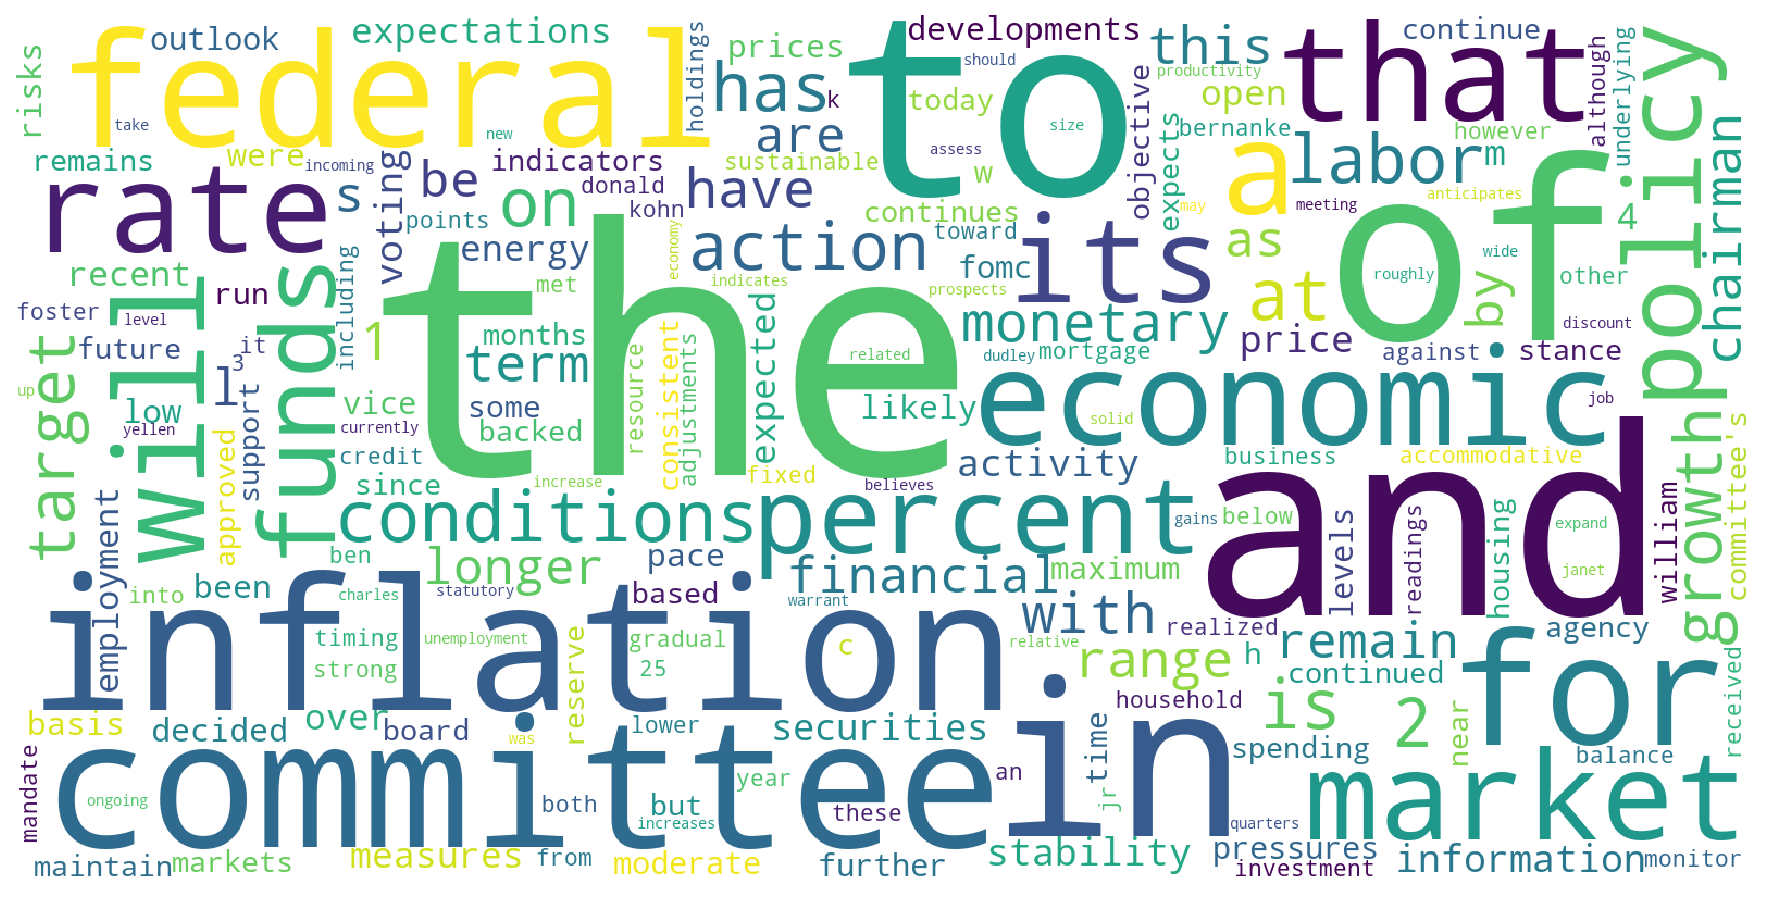

In [768]:
wordcloud = WordCloud(background_color="white",width=1600,height=800).generate_from_frequencies(t.word_counts)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Graph Effective vs Target Federal Funds Rate

This graph displays the similarity of the Target Fed Funds rate set by the FOMC and the actual Fed Funds rate used by banks. Delta shows the change in the Target Fed Funds rate after each meeting.

From around 2008 to 2015, the Target Fed Funds rate was set at 0-0.25%. This is an example of how the recession affected the discussions held by the FOMC, which can be seen in our prediction.

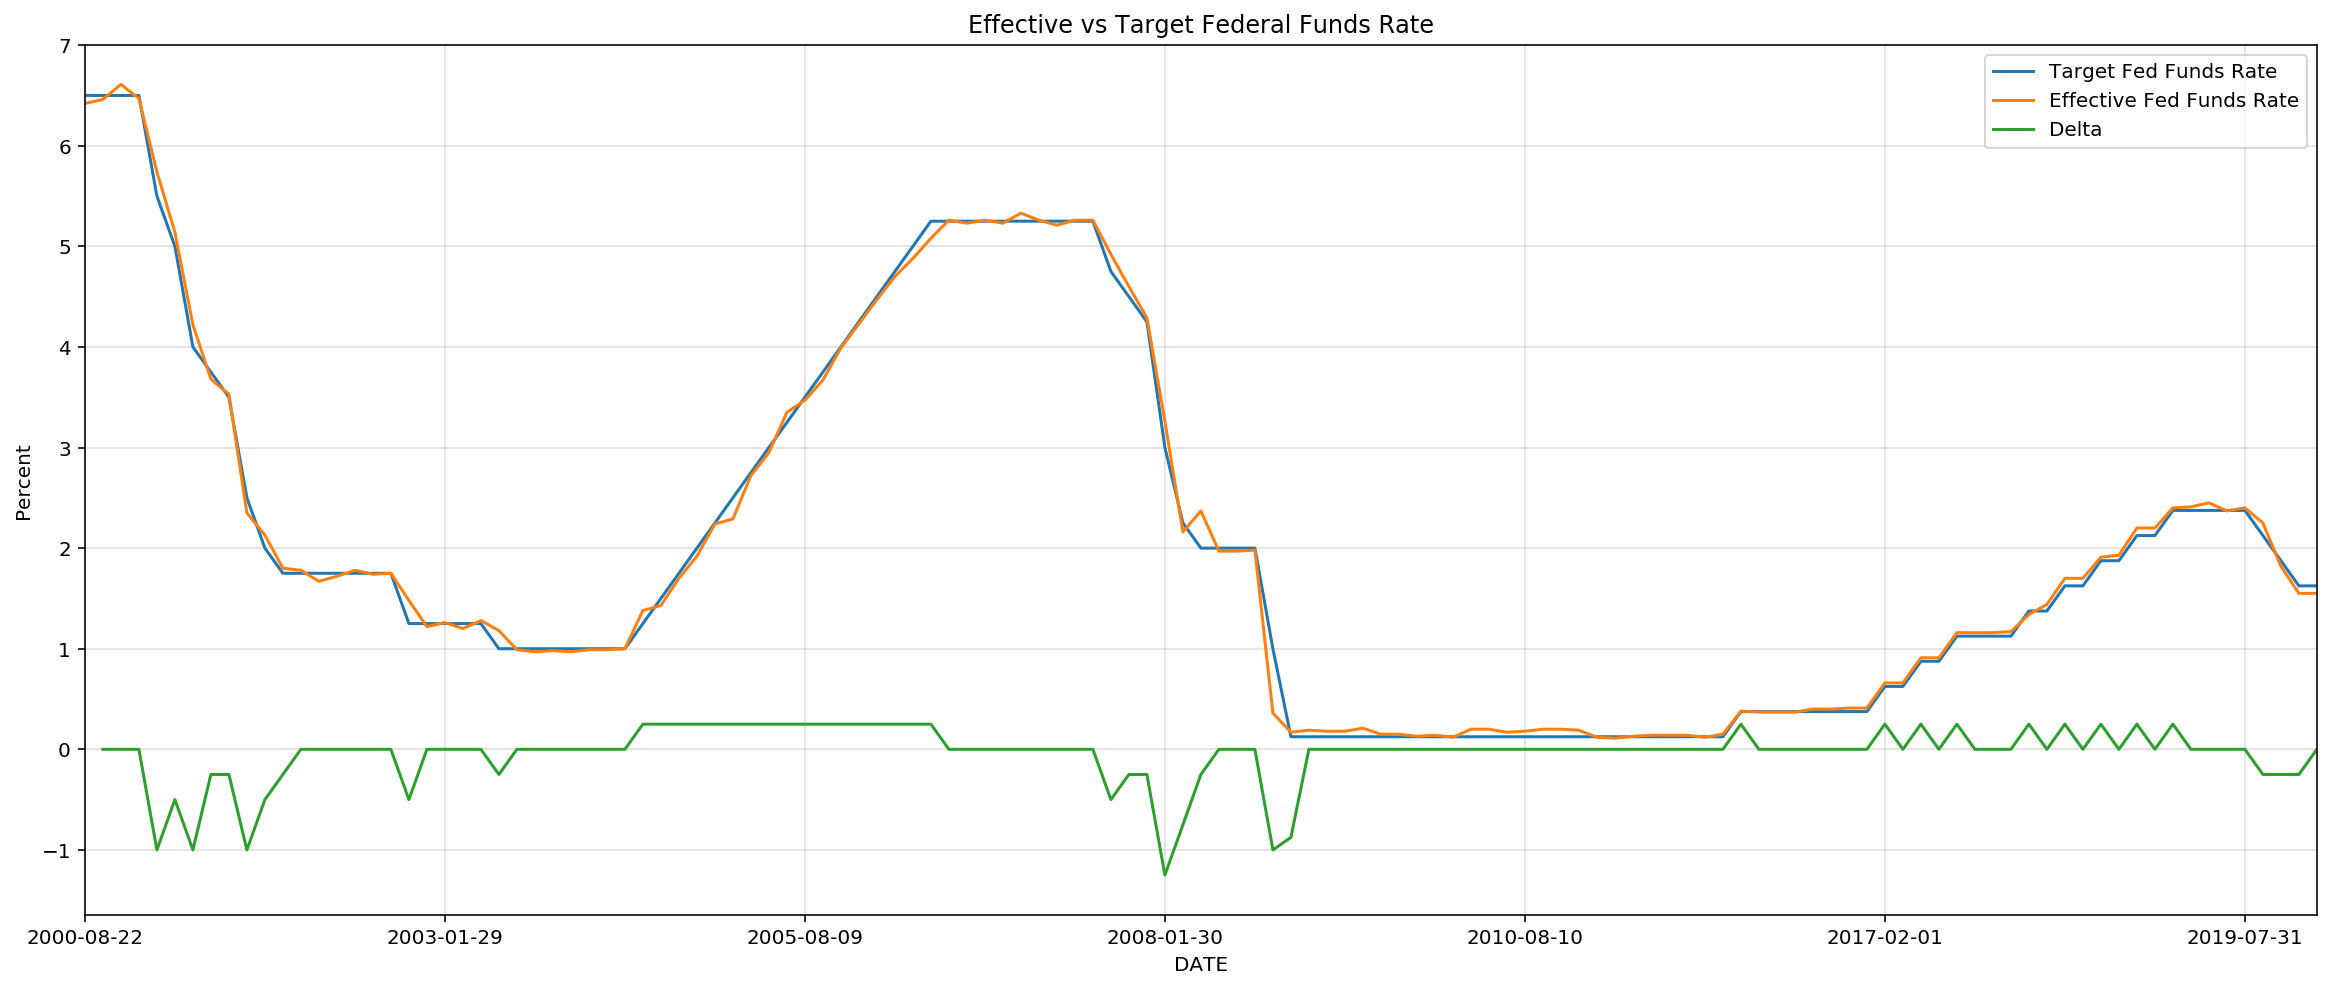

In [769]:
df.plot(y=['Target Fed Funds Rate','Effective Fed Funds Rate','Delta'],figsize=(20,8))
plt.title("Effective vs Target Federal Funds Rate")
plt.ylabel("Percent")
plt.grid(True,alpha=0.4)
plt.show()

In [770]:
print("Target Fed Funds Rate:")
print("\tMean:",df["Target Fed Funds Rate"].mean(),"percent")
print("\tMedian:",df["Target Fed Funds Rate"].median(),"percent")
print("\tMin:",df["Target Fed Funds Rate"].min(),"percent")
print("\tMax:",df["Target Fed Funds Rate"].max(),"percent")

Target Fed Funds Rate:
	Mean: 2.046 percent
	Median: 1.625 percent
	Min: 0.125 percent
	Max: 6.5 percent


## Training

We used **Natural Language Processing (NLP)** and converted the FOMC statements to a matrix. We can now use a **Long Short-Term Memory (LSTM)** network to predict the target federal funds rate. An LSTM is a type of Recurrent Neural Network capable of remembering previous inputs, which is useful for connecting sequences and time-series data. They also prevent exploding and vanishing gradient problems that may occur with traditional RNN's.

#### Split dataset into training and testing

In [0]:
data = df.drop("Effective Fed Funds Rate",axis=1)
train=data.sample(frac=0.9)
test=data.drop(train.index)

X_train = train.drop(["Target Fed Funds Rate","Delta"],axis=1).to_numpy()
y_train = train["Target Fed Funds Rate"]

X_test = test.drop(["Target Fed Funds Rate","Delta"],axis=1).to_numpy()
y_test = test["Target Fed Funds Rate"]

#### Reshape X for LSTM

In [0]:
X_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))

#### Create Model

The activation of the output functin is a **Rectified Linear Unit (relu)**activation function because the Target Fed Funds rate data is nonlinear.

The loss function of the model is **Mean Absolute Error (MAE)**, which is not as affected by outliers as Mean Squared Error (MSE). The first few years has a higher target rate than the recent years, so MSE easily predicted the recent years but had difficulty predicting the first two or three years in the dataset. This issue is solved with MAE.

In [773]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1],X_train.shape[2])
))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=1,activation="relu"))
model.compile(loss='mae',optimizer="adam",metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 128)               791040    
_________________________________________________________________
flatten_45 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 791,169
Trainable params: 791,169
Non-trainable params: 0
_________________________________________________________________


#### Train Model

In [774]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Train on 100 samples, validate on 12 samples
Epoch 1/10
100/100 [==============================] - 2s 18ms/sample - loss: 1.7109 - root_mean_squared_error: 2.4097 - val_loss: 1.0158 - val_root_mean_squared_error: 1.3072
Epoch 2/10
100/100 [==============================] - 0s 650us/sample - loss: 1.0167 - root_mean_squared_error: 1.4871 - val_loss: 0.7022 - val_root_mean_squared_error: 0.9300
Epoch 3/10
100/100 [==============================] - 0s 615us/sample - loss: 0.7593 - root_mean_squared_error: 1.1075 - val_loss: 0.5940 - val_root_mean_squared_error: 0.7447
Epoch 4/10
100/100 [==============================] - 0s 570us/sample - loss: 0.5783 - root_mean_squared_error: 0.8861 - val_loss: 0.4368 - val_root_mean_squared_error: 0.5235
Epoch 5/10
100/100 [==============================] - 0s 618us/sample - loss: 0.3954 - root_mean_squared_error: 0.6620 - val_loss: 0.3617 - val_root_mean_squared_error: 0.4939
Epoch 6/10
100/100 [==============================] - 0s 679us/sample - loss

#### Graph Loss vs Epoch

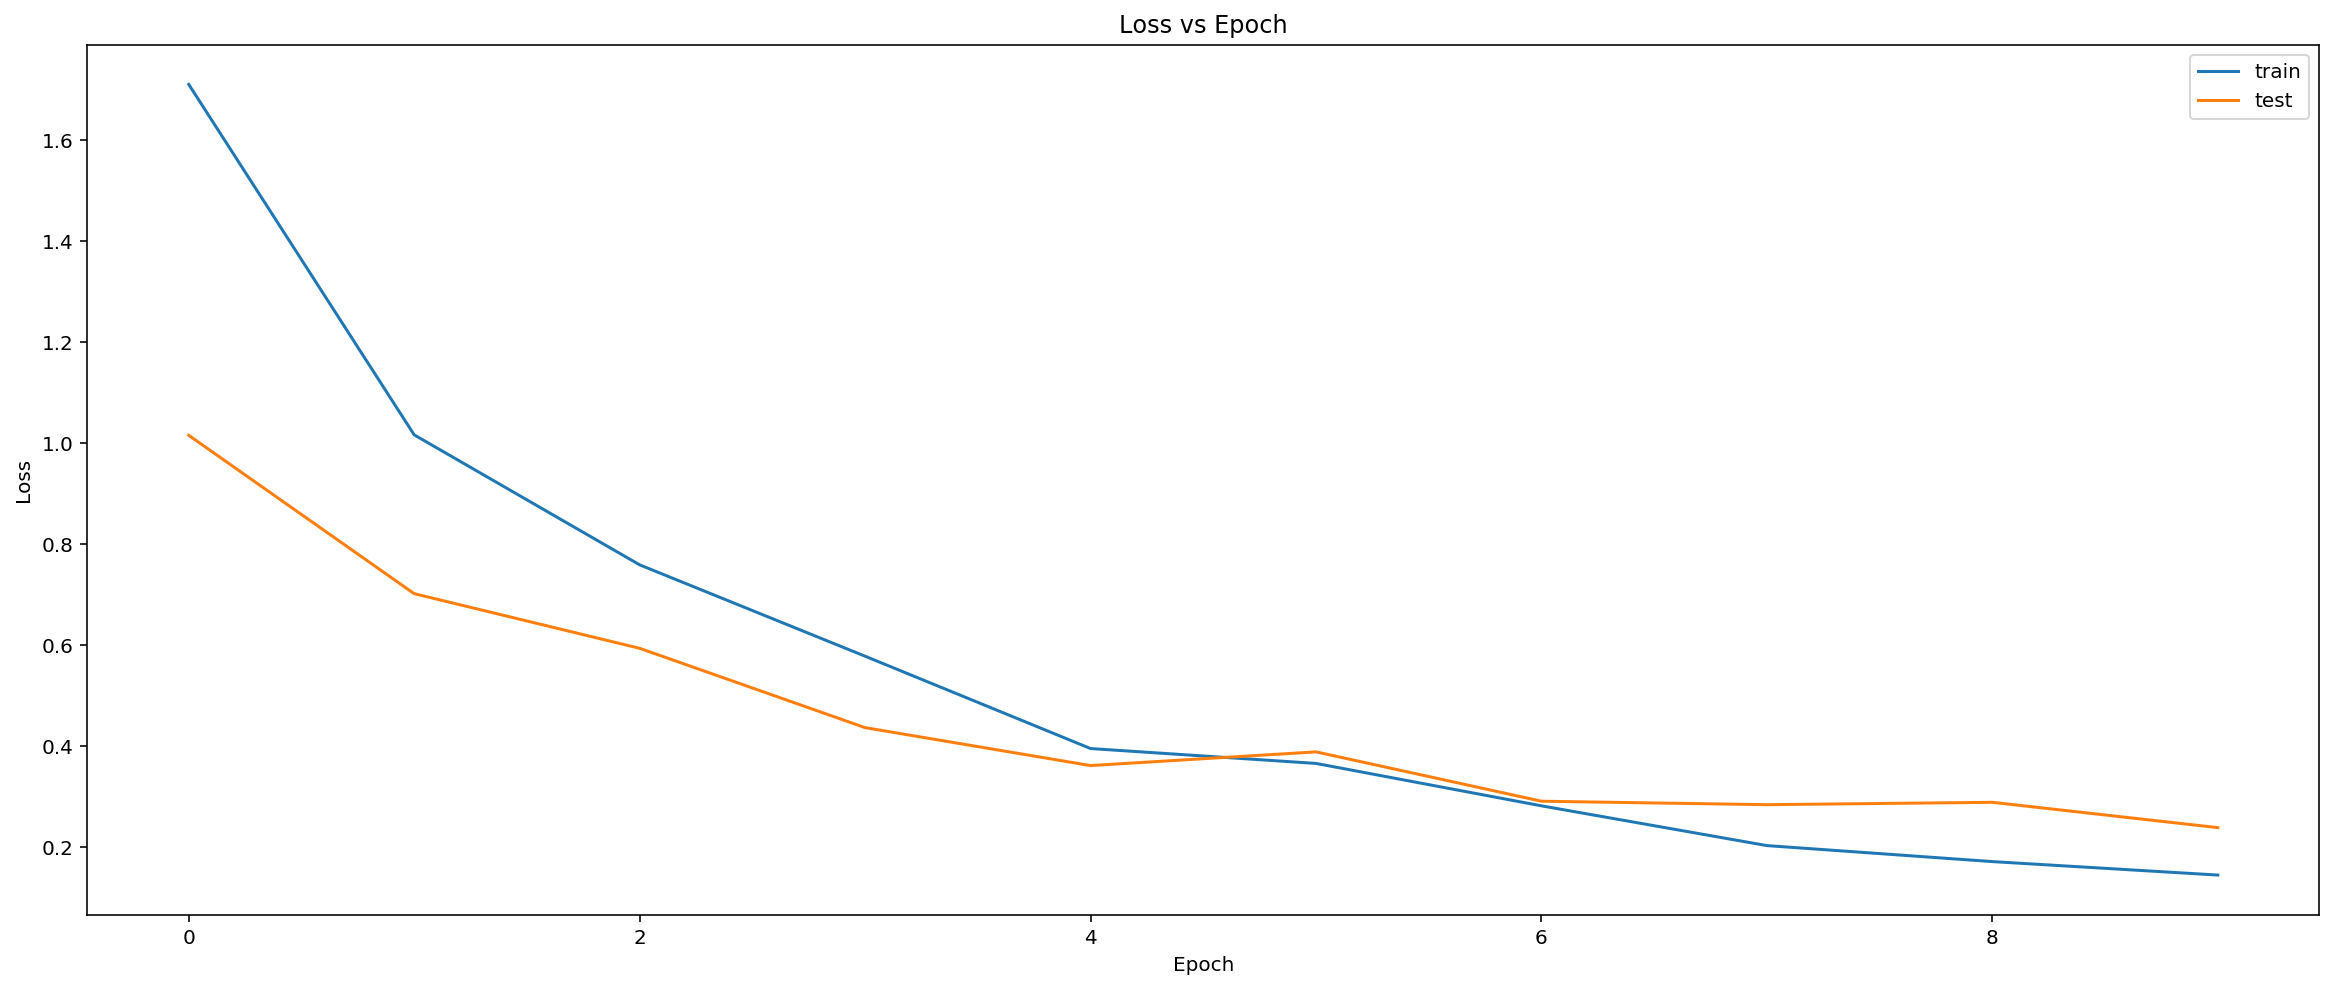

In [775]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend();
plt.show()

In [776]:
loss = model.evaluate(X_train, y_train)
y_pred = model.predict(X_test)
y_pred,y_test

112/112 [==============================] - 0s 188us/sample - loss: 0.1547 - root_mean_squared_error: 0.2174


(array([[5.2080812 ],
        [1.384894  ],
        [1.5283846 ],
        [0.90908676],
        [2.2819357 ],
        [4.931783  ],
        [2.945243  ],
        [2.260068  ],
        [0.        ],
        [0.        ],
        [0.22634906],
        [1.6775028 ],
        [1.8914348 ]], dtype=float32), DATE
 2000-08-22    6.500
 2002-12-10    1.250
 2003-05-06    1.250
 2003-09-16    1.000
 2004-09-21    1.750
 2007-08-07    5.250
 2008-01-30    3.000
 2008-06-25    2.000
 2009-01-28    0.125
 2010-01-27    0.125
 2015-12-16    0.125
 2018-08-01    1.875
 2018-11-08    2.125
 Name: Target Fed Funds Rate, dtype: float64)

#### Graph Predictions vs Target Federal Funds Rate

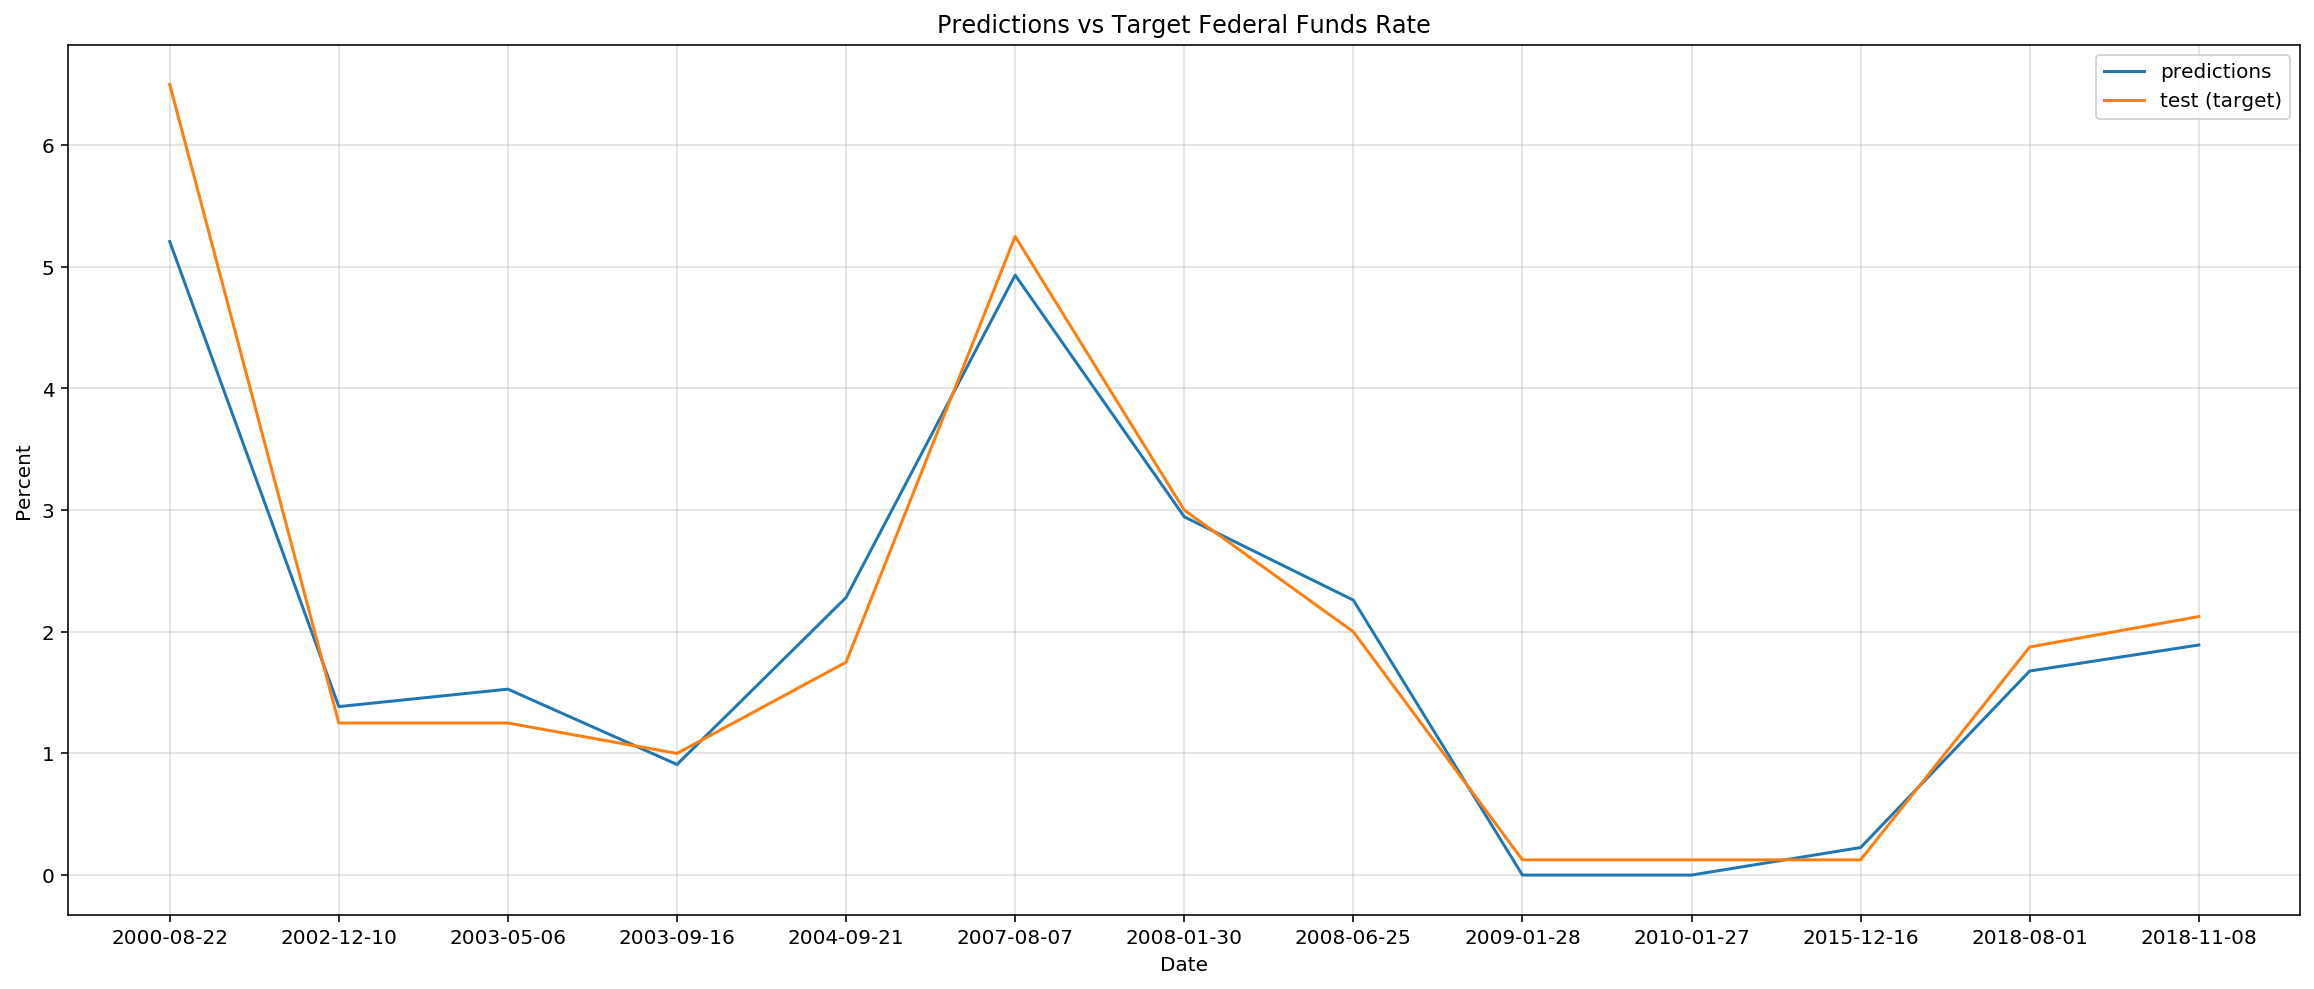

In [777]:
plt.figure(figsize=(20,8))
plt.plot(y_pred, label='predictions')
plt.plot(y_test, label='test (target)')
plt.legend();
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("Predictions vs Target Federal Funds Rate")
plt.grid(True,alpha=0.4)
plt.show()